# Проект: классификация (Machine Learning)

In [1]:
# Импортируем необходимы библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков.
round(df.isna().mean()*df.shape[0], 0)

age           0.0
job           0.0
marital       0.0
education     0.0
default       0.0
balance      25.0
housing       0.0
loan          0.0
contact       0.0
day           0.0
month         0.0
duration      0.0
campaign      0.0
pdays         0.0
previous      0.0
poutcome      0.0
deposit       0.0
dtype: float64

In [5]:
# Оцениваем пропуски в признаке "job"
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [6]:
# преобразуtv признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
df['balance'] = df['balance'].apply(lambda x: make_convert(x))
df['balance'] = df['balance'].astype('float64')
print(f'Среднее значение по признаку balance: {round(df.balance.mean(),3)}')

Среднее значение по признаку balance: 1529.129


In [7]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print(f'Среднее значение по признаку balance: {round(df.balance.mean(),3)}')

Среднее значение по признаку balance: 1526.936


In [8]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace('unknown', 'management')
df['education'] = df['education'].replace('unknown', 'secondary')
mean_price = df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean()
print(f'Средний баланс у managment с уровнем образования secondary равна {round(mean_price, 3)}')

Средний баланс у managment с уровнем образования secondary равна 1598.883


In [9]:
# удалим все выбросы для признака balance
# создаем функцию для оценки выбросов по методу Тьюки
def check_outliers_iqr(df, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale == True:
        x = np.log(df[feature])
    else:
        x = df[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) | (x < upper_bound)]
    print('Верхняя граница:', upper_bound)
    print('Нижняя граница:', lower_bound)
    return outliers, cleaned
outliers, cleaned = check_outliers_iqr(df, 'balance')
print('Число объектов после удаления равно:', df.shape[0] - outliers.shape[0])
# новый датасет
df_new = df.drop(labels=list(outliers.index), axis=0)
print('Размер нового датасета:', df_new.shape)

Верхняя граница: 4063.0
Нижняя граница: -2241.0
Число объектов после удаления равно: 10105
Размер нового датасета: (10105, 17)


## Часть 2:  Разведывательный анализ

Клиенты, которые не открыли депозит: 53.68%
Клиенты, которые открыли депозит: 46.32%
Число клиентов, которые открыли депозит: 4681


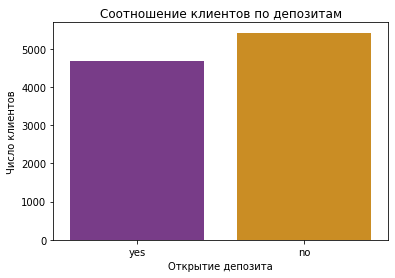

In [10]:
# изучаем соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
deposit = sns.countplot(x='deposit', data=df_new, palette='CMRmap')
deposit.set_title('Соотношение клиентов по депозитам')
deposit.set_ylabel('Число клиентов')
deposit.set_xlabel('Открытие депозита')
class_percent = df_new['deposit'].value_counts(normalize=True) * 100
print('Клиенты, которые не открыли депозит: {:.2f}%'.format(class_percent[0]))
print('Клиенты, которые открыли депозит: {:.2f}%'.format(class_percent[1]))
print('Число клиентов, которые открыли депозит:', df_new[df_new['deposit'] == 'yes']['deposit'].count())

In [11]:
#рассчитываем описательные статистики для количественных переменных
df_new[['age', 'duration']].describe()

,age,duration
count,10105.000000,10105.000000
mean,40.895497,368.742603
std,11.734931,346.651524
min,18.000000,2.000000
25%,32.000000,137.000000
50%,38.000000,252.000000
75%,48.000000,490.000000
max,95.000000,3881.000000


Число месяцев, в которых проводилась маркетинговая компания: 12
Число сфер занятости среди клиентов банка равно: 11


,month,job
count,10105,10105
unique,12,11
top,may,management
freq,2617,2315


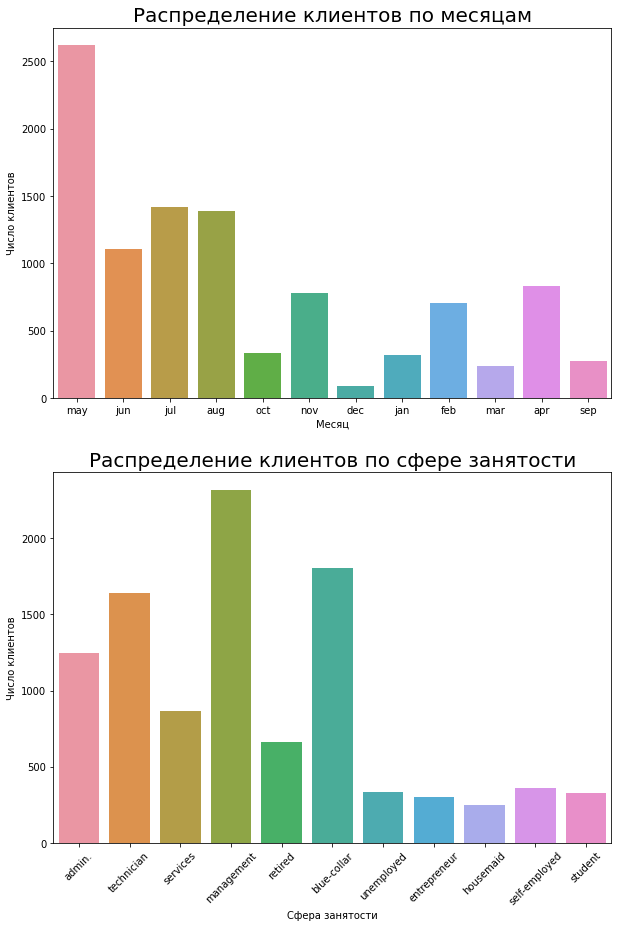

In [12]:
#рассчитываем описательные статистики для категориальных переменных
print('Число месяцев, в которых проводилась маркетинговая компания:',df_new['month'].nunique())
print('Число сфер занятости среди клиентов банка равно:', df['job'].nunique())
display(df_new[['month', 'job']].describe(include='object'))
#постройте визуализации, иллюстрирующие результаты
fid, axes = plt.subplots(2, 1, figsize=(10, 15))
sns.countplot(x=df_new['month'], ax=axes[0])
sns.countplot(x=df_new['job'], ax=axes[1])
axes[0].set_title('Распределение клиентов по месяцам', fontsize=(20))
axes[0].set_xlabel('Месяц', fontsize=(10))
axes[0].set_ylabel('Число клиентов', fontsize=(10))
axes[1].set_title('Распределение клиентов по сфере занятости', fontsize=(20))
axes[1].set_xlabel('Сфера занятости', fontsize=(10))
axes[1].set_ylabel('Число клиентов', fontsize=(10))
axes[1].tick_params(axis='x',labelrotation=45)

In [13]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
display(df_new.groupby('poutcome')['deposit'].value_counts())

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Клиенты, которые согласились на депозит в прошлой маркетинговой кампании в 10 раз больше соглашаются на открытие депозита в новой маркетинговой кампании.

Text(0, 0.5, 'Месяц')

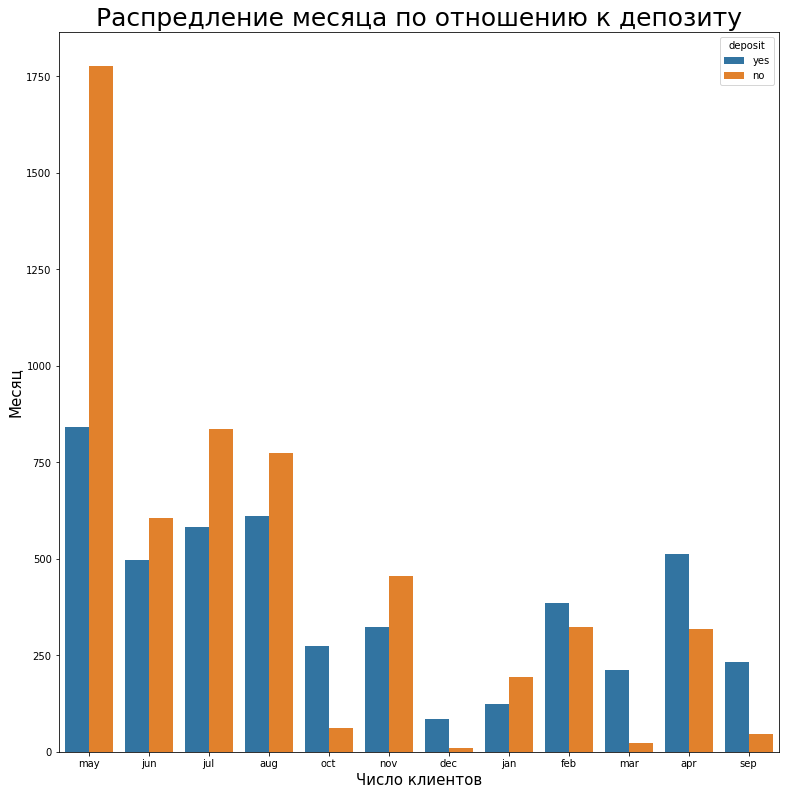

In [14]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
fig = plt.figure(figsize=(10, 10))
fig.add_axes([0,0,1,1])
figure = sns.countplot(
    x=df_new['month'],
    hue=df_new['deposit']
)
figure.set_title('Распредление месяца по отношению к депозиту', fontsize = 25)
figure.set_xlabel('Число клиентов', fontsize = 15)
figure.set_ylabel('Месяц', fontsize = 15)

Таким месяцем оказался - май.

In [15]:
# создаем возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(age):
    if age < 30:
        return '<30'
    if 30 < age < 40:
        return '30-40'
    if 40 < age < 50:
        return '40-50'
    if 50 < age < 60:
        return '50-60'
    else:
        return '60+'
df_new['age_group'] = df_new.age.apply(lambda x: age_group(x))

Text(0.5, 0, 'Возрастные группы')

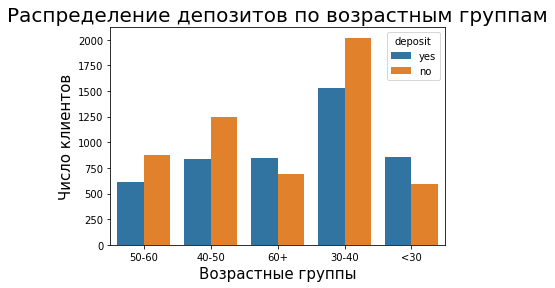

In [16]:
# визуализируем данные по открытию депозита в зависимости от возрастной группы
age_group = sns.countplot(x=df_new['age_group'], hue=df_new['deposit'])
age_group.set_title('Распределение депозитов по возрастным группам', fontsize=20)
age_group.set_ylabel('Число клиентов', fontsize=15)
age_group.set_xlabel('Возрастные группы', fontsize=15)


Text(0.5, 0, 'Семейный статус')

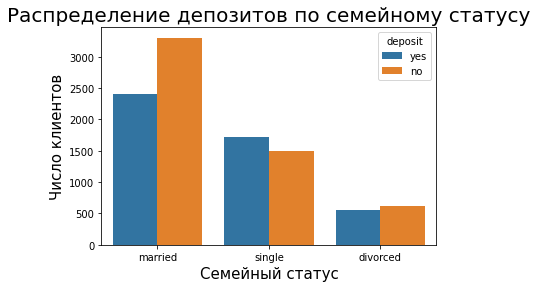

In [17]:
# строим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital = sns.countplot(x=df_new['marital'], hue=df_new['deposit'])
marital.set_title('Распределение депозитов по семейному статусу', fontsize=20)
marital.set_ylabel('Число клиентов', fontsize=15)
marital.set_xlabel('Семейный статус', fontsize=15)

Text(0.5, 0, 'уровень образования')

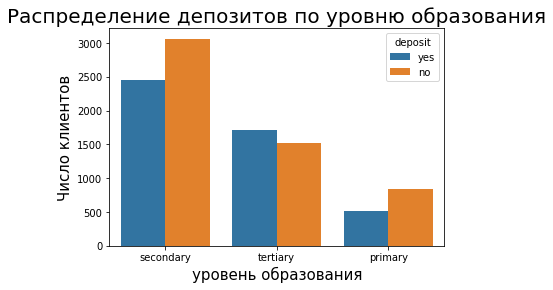

In [18]:
# строим визуализации для открывших и неоткрывших депозит в зависимости от образования
marital = sns.countplot(x=df_new['education'], hue=df_new['deposit'])
marital.set_title('Распределение депозитов по уровню образования', fontsize=20)
marital.set_ylabel('Число клиентов', fontsize=15)
marital.set_xlabel('уровень образования', fontsize=15)

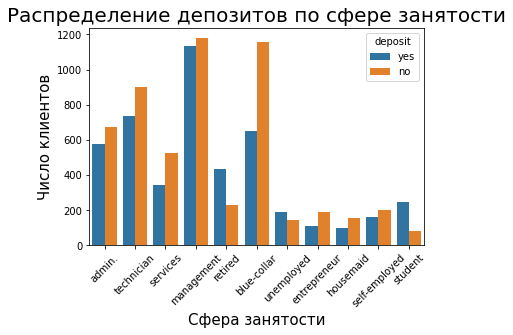

In [19]:
# строим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
marital = sns.countplot(x=df_new['job'], hue=df_new['deposit'])
marital.set_title('Распределение депозитов по сфере занятости', fontsize=20)
marital.set_ylabel('Число клиентов', fontsize=15)
marital.set_xlabel('Сфера занятости', fontsize=15)
marital.tick_params(axis='x',labelrotation=45)

Text(0.5, 15.0, 'Количество клиентов')

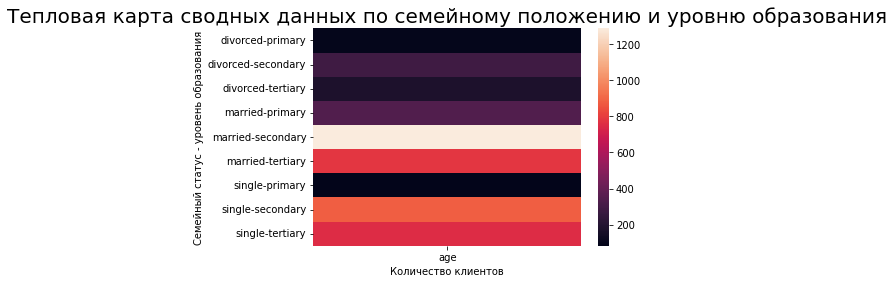

In [20]:
# строим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
deposit_yes = df_new[df_new['deposit'] == 'yes']
deposit_no = df_new[df_new['deposit'] == 'no']
pivot = pd.pivot_table(deposit_yes, index=['marital', 'education'], values=['age'], aggfunc=len)
heatmap = sns.heatmap(pivot)
heatmap.set_title('Тепловая карта сводных данных по семейному положению и уровню образования', fontsize=20)
heatmap.set_ylabel('Семейный статус - уровень образования', fontsize=10)
heatmap.set_xlabel('Количество клиентов', fontsize=10)

## Часть 3: преобразование данных

In [21]:
# преобразую уровни образования
LE = LabelEncoder()
df_new['education'] = LE.fit_transform(df_new['education'])
print('Сумма получившихся значений в признаке "education":',df_new['education'].sum())

Сумма получившихся значений в признаке "education": 11995


In [22]:
# преобразуем бинарные переменные в представление из нулей и единиц
df_new['deposit'] = df_new['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_new['age_group'] = LE.fit_transform(df_new['age_group'])
df_new['default'] = df_new['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_new['housing'] = df_new['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_new['loan'] = df_new['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [23]:
# создаем дамми-датасет
df_new = pd.get_dummies(df_new)

<Axes:>

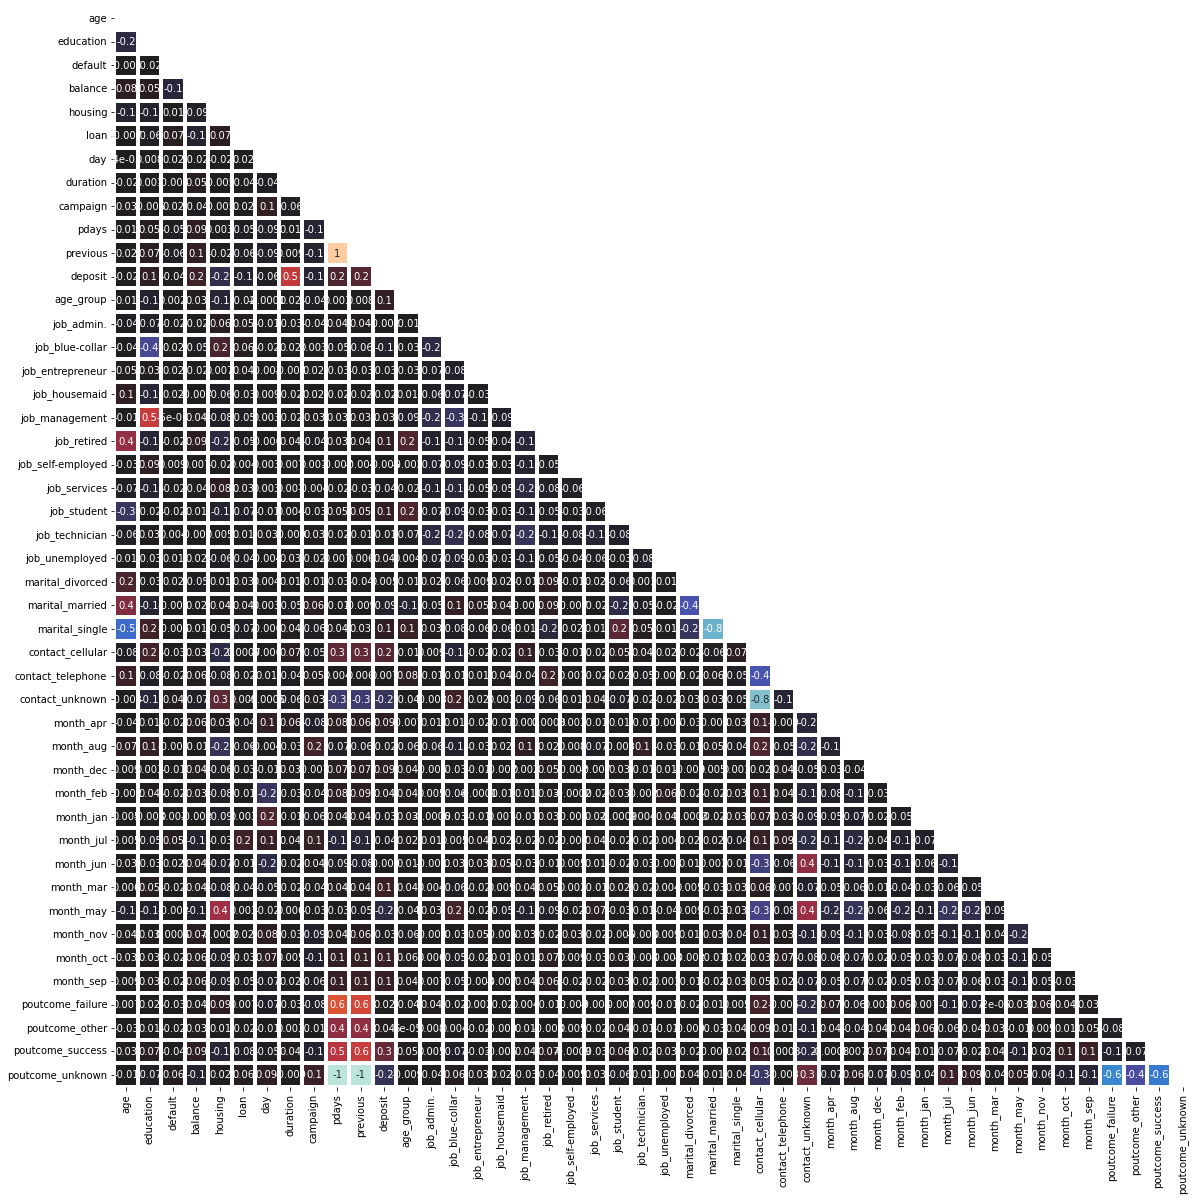

In [24]:
# строим корреляционную матрицу и оцениваем данные на предмет наличия мультиколлинеарности
matrix = np.triu(
    df_new.corr(method='spearman')
)
fig = plt.figure(figsize=(15,15))
axes = fig.add_axes([0,0,1,1])
sns.heatmap(
    df_new.corr(method='spearman'),
    annot=True,
    fmt='.1g',
    vmin = -1,
    vmax = 1,
    center = 0,
    linewidths=4,
    linecolor='white',
    cbar=False,
    mask=matrix
)

In [25]:
# выделяем целевую переменную
X = df_new.drop(['deposit'], axis=1)
y = df_new['deposit']
# Делим датасет для определения наиболее значимых признаков для открытия депозита
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [26]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки:', X_test.shape[0])

Размер тестовой выборки: 3335


In [27]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [28]:
# Определяем датасет с наиболее значимыми признаками
X = df_new[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]
y = df_new['deposit']
# Делим на тестовый и тренировочный датасеты
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [29]:
# нормализуем данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [32]:
# обучаем логистическую регрессию и рассчитываем метрики качества
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=10000)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred), 2))

Accuracy: 0.81


### Задания 2,3,4

In [34]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train_scaled, y_train)
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)
print('Train:\n',metrics.classification_report(y_train, y_pred_train))
print('Test:\n',metrics.classification_report(y_test, y_pred_test))

Train:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

Test:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



In [40]:
# подбираем оптимальные параметры с помощью gridsearch
grid_params = {
    'min_samples_split':[2,3,4,5,6,7,8,9,10],
    'max_depth':[3,4,5,6,7]
}
from sklearn import model_selection
grid = model_selection.GridSearchCV(
    estimator=dt,
    param_grid=grid_params,
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)
y_pred_test = grid.predict(X_test_scaled)
print('F1-score Test:', round(metrics.f1_score(y_test, y_pred_test), 2))

F1-score Test: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [42]:
# обучаем на данных случайный лес
from sklearn.ensemble import RandomForestClassifier
rft = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rft.fit(X_train_scaled, y_train)
y_pred_train = rft.predict(X_train_scaled)
print('Train:\n', metrics.classification_report(y_train, y_pred_train))
y_pred_test = rft.predict(X_test_scaled)
print('Test:\n', metrics.classification_report(y_test, y_pred_test))


Train:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      3634
           1       0.83      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Test:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [43]:
# используем для классификации градиентный бустинг и сравниваем качество со случайным лесом
grad_boost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
grad_boost.fit(X_train_scaled, y_train)
y_pred_train = grad_boost.predict(X_train_scaled)
print('Gradient boosting Train:\n', metrics.classification_report(y_train, y_pred_train))
y_pred_test = grad_boost.predict(X_test_scaled)
print('Gradient boosting Test:\n', metrics.classification_report(y_test, y_pred_test))

Gradient boosting Train:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Gradient boosting Test:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335



Целевая метрика не изменилась на тестовых данных.

In [44]:
# объединим с помощью стекинга
estimators = [
    ('dt', ensemble.RandomForestClassifier(
        n_estimators=100, criterion='gini', 
        min_samples_leaf=5, max_depth=10, random_state=42)),
    
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,n_estimators=300,
        min_samples_leaf=5,max_depth=5,random_state=42),),
    
    ('lr', linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000))]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'))],
                   final_estimator=LogisticRegression(random_state=42))

In [45]:
# Выведим метрики стэкинга
y_pred_train = stack.predict(X_train_scaled)
print('Stacking Train:\n', metrics.classification_report(y_train, y_pred_train))
y_pred_test = stack.predict(X_test_scaled)
print('Stacking Test:\n', metrics.classification_report(y_test, y_pred_test))

Stacking Train:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3634
           1       0.85      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.86      0.87      0.86      6770
weighted avg       0.87      0.87      0.87      6770

Stacking Test:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Удалось поднять на 1% целевую метрику

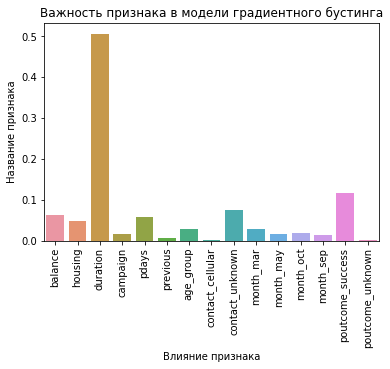

In [46]:
# оцениваем, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feat_imp = pd.concat([pd.DataFrame(grad_boost.feature_names_in_, columns=['Features name']),pd.DataFrame(grad_boost.feature_importances_, columns=['Features impact'])], axis=1)
feat = sns.barplot(
    x=feat_imp['Features name'],
    y=feat_imp['Features impact']
)
feat.set_title('Важность признака в модели градиентного бустинга')
feat.set_ylabel('Название признака')
feat.set_xlabel('Влияние признака')
feat.tick_params('x', rotation=90)

In [47]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,random_state=42
    )
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    return score
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-16 13:21:02,196] A new study created in memory with name: RandomForestClassifier
[I 2022-11-16 13:21:02,709] Trial 0 finished with value: 0.8681490761039775 and parameters: {'n_estimators': 102, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8681490761039775.
[I 2022-11-16 13:21:03,260] Trial 1 finished with value: 0.8480973175296319 and parameters: {'n_estimators': 122, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8681490761039775.
[I 2022-11-16 13:21:04,027] Trial 2 finished with value: 0.851973171112151 and parameters: {'n_estimators': 164, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8681490761039775.
[I 2022-11-16 13:21:04,726] Trial 3 finished with value: 0.849554757069208 and parameters: {'n_estimators': 151, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8681490761039775.
[I 2022-11-16 13:21:05,327] Trial 4 finished with value: 0.8896875 and parameters: {'n_estimators

In [48]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 101, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [49]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Вывод: оптимальным значением метрики F1-score является значение 0.82. На следующей маркетинговой кампании следует уделить наибольшее внимание:
- неважно как мы взаимодействуем с клиетом, главное чтоб была с ним связь;
- важна продолжительность контакта;
- и не затягивать с предложением открыть депозит.